In [46]:
# Import machine-learning packages
import torch
from torch import nn

# Import plotting packages
from IPython.display import Image, HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import time
import base64
import numpy as np

%matplotlib inline

In [47]:
import xarray as xr

In [48]:
data = xr.open_dataset("../data4training/icepack.h.20150101.nc")
data_x = [data.vice.values[:-1, 2],data.sst.values[:-1, 2], data.sss.values[:-1, 2], data.Tair.values[:-1, 2],data.Qa.values[:-1, 2],data.frain.values[:-1, 2],data.fsnow.values[:-1, 2],data.flw.values[:-1, 2], data.fsw.values[:-1, 2]]
data_y = data.vice.values[1:,2]

In [19]:
ind = np.arange(8759)
index_train = [i for i in ind if i % 7 in [0,1,2,3,4]]
index_test = [i for i in ind if i % 7 in [5,6]]
print(ind.size, len(index_train)+len(index_test))

8759 8759


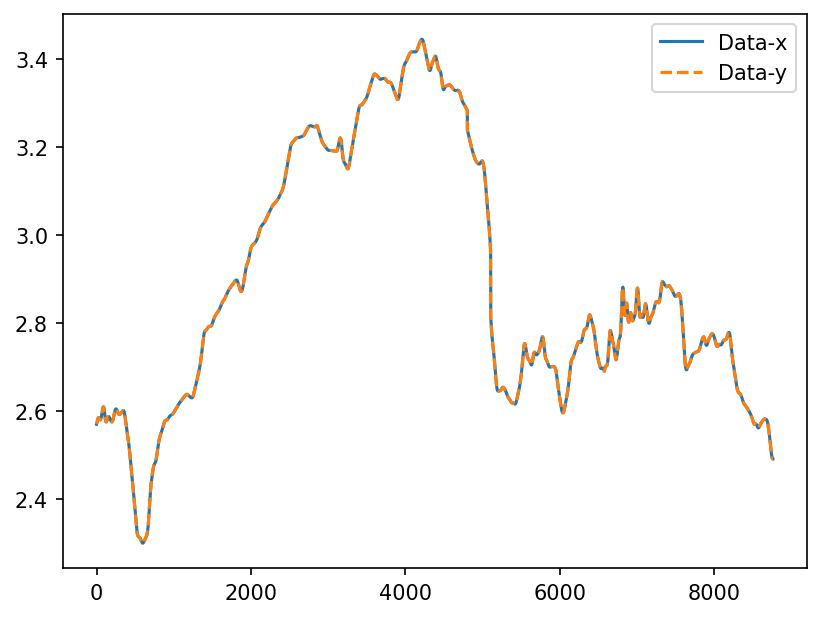

In [4]:
plt.figure(dpi=150)

plt.plot(data_x[0], "-", markersize=1.5, label="Data-x")
plt.plot(data_y, "--", markersize=0.1, label="Data-y")
plt.legend()


In [36]:
n = len(index_train)
x = torch.ones(n,9)
y = torch.ones(n,1)
for i in range(n):
    for j in range(9):
        x[i][j] = data_x[j][index_train[i]]
    y[i] = data_y[index_train[i]]


In [37]:
class Simple_Neural_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.Dense1 = nn.Linear(9, 30)
        self.Dense2 = nn.Linear(30, 30)
        self.Dense3 = nn.Linear(30, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.Dense1(x)
        x = self.relu(x)
        x = self.Dense2(x)
        x = self.relu(x)
        x = self.Dense3(x)

        return x



In [38]:
neural_net = Simple_Neural_Net()

In [39]:
# Here we use the Adam optimizer.
learning_rate = 0.005
optimizer = torch.optim.Adam(neural_net.parameters())

In [40]:
# MSE loss function
loss_fn = torch.nn.MSELoss()

In [41]:
def train_step(model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices

    pred = model(x)
    loss = loss_fn(pred, y)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss = loss.item()
    return loss

In [42]:
epochs = 1000
Loss = np.zeros(epochs)
for t in range(epochs):
    Loss[t] = train_step(neural_net, loss_fn, optimizer)
    if np.mod(t, 200) == 0:
        print(f"Loss at Epoch {t+1} is ", Loss[t])

Loss at Epoch 1 is  384.5927734375
Loss at Epoch 201 is  0.11888919025659561
Loss at Epoch 401 is  0.028935380280017853
Loss at Epoch 601 is  0.020083079114556313
Loss at Epoch 801 is  0.015092463232576847


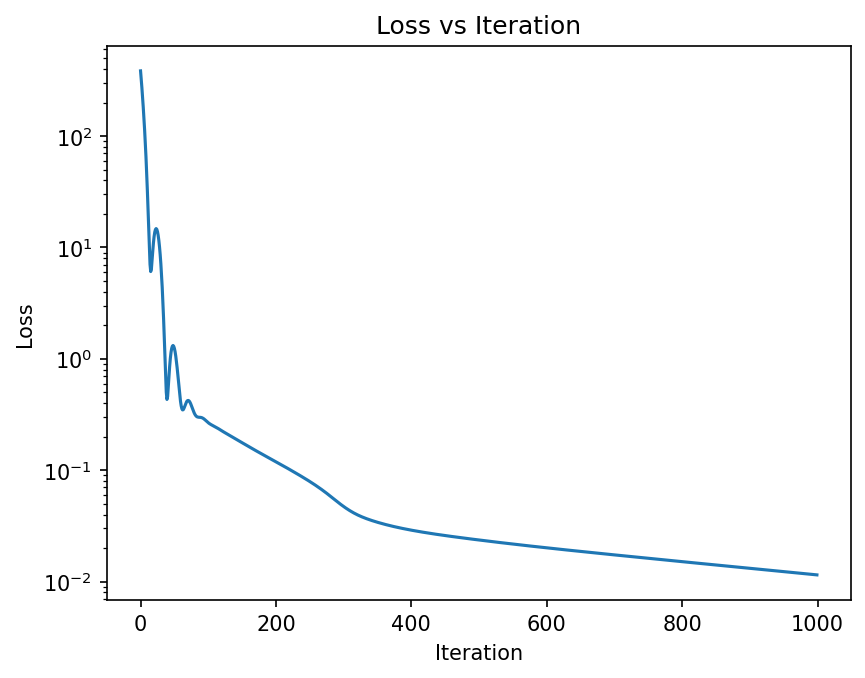

In [43]:
plt.figure(dpi=150)
plt.plot(Loss)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss vs Iteration")
plt.show()

In [44]:
# Generate some points where the predictions of the model will be tested.
# Here we pick the testing domain to be larger than the training domain to check if the model
# has any skill at extrapolation.
x_test = torch.ones(len(index_test),9)
y_test = torch.ones(len(index_test))
for i in range(len(index_test)):
    for j in range(9):
        x_test[i][j] = data_x[j][index_test[i]]
    y_test[i] = data_y[index_test[i]]

# Generate the predictions from the trained model.
pred = neural_net(x_test).detach().numpy()

In [62]:
# Generate some points where the predictions of the model will be tested.
# Here we pick the testing domain to be larger than the training domain to check if the model
# has any skill at extrapolation.

y_ml_pred = torch.zeros(len(index_test)+1)
x_test = torch.ones(9)
for i in range(len(index_test)):
    for j in range (1,9):  # to avoid writing in the place of predicted field 
        x_test[j] = data_x[j][index_test[i]]    
    if i == 0:
        x_test[0] = x_test[index_test[i]]
    else:
        x_test[0] = pred
    pred = neural_net(x_test).detach().numpy()
    pred = torch.from_numpy(pred)
    y_ml_pred[i+1] = pred


# store icepack output for comparison with predicted result
y_test = torch.ones(len(index_test))
for i in range(len(index_test)):
    y_test[i] = data_y[index_test[i]]



6259


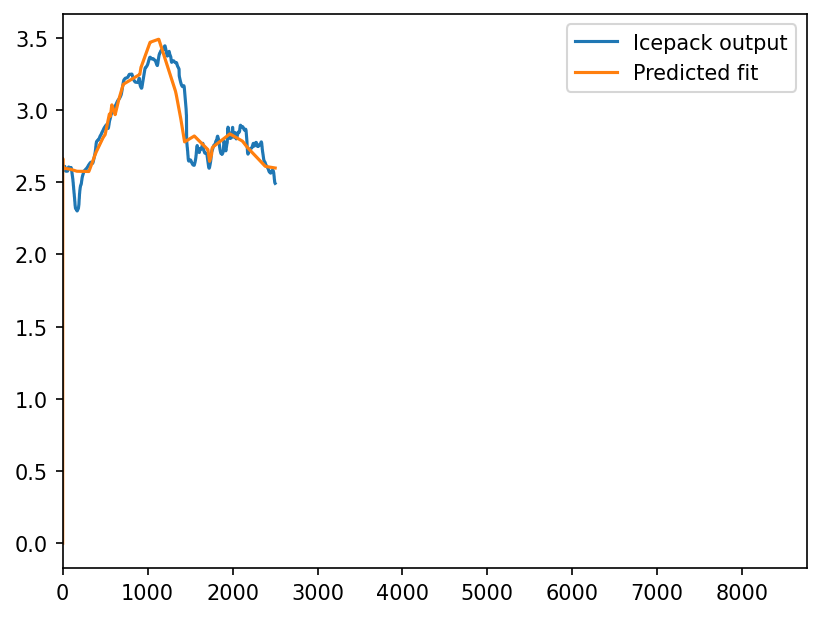

In [63]:
plt.figure(dpi=150)

plt.plot(y_test, markersize=0.5, label="Icepack output")
plt.plot(y_ml_pred, markersize=0.5, label="Predicted fit")
plt.xlim(0,8760)
plt.legend()
print(n+1+1)